# MIDS W261 HW7

## Undirected toy network dataset

In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

    A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

    (node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


## Directed toy network dataset

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

    A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

    (node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

## HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

Undirected Graph Data

    1	{'2': 1,'5': 1}
    2	{'1': 1,'3': 1,'4': 1,'5': 1}
    3	{'2': 1, '4': 1}
    4	{'2': 1,'3': 1,'5': 1}
    5	{'1': 1, '2': 1, '4': 1}


In [2]:
# Jupyter requires this for MRJob to reload classes properly
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
%%writefile MrJobGraph70.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from sys import maxint
import re
#
# Visit all nodes of the graph to calculate the minimum distance of the graph 
#         
class MrJobGraph70(MRJob):

    def configure_options(self):
        super(MrJobGraph70, self).configure_options()    
    
    # key = node, value = {},status
    # {} = dictionary of node:distances
    # status = one of Q,V,U
    def mapper(self, _, line):
        q = re.split('\t',line.strip())
        node = q[0].strip('"')
        value = eval(q[1].strip())
        neighbors = value[0]
        weight = int(value[1])
        status = value[2].strip('"')
        path = value[3]
        if status == 'Q':
            for neighbor in neighbors:
                path_to_node = list(path)
                path_to_node.append(neighbor)
                yield neighbor.strip('"'), (None, weight+1, 'Q', path_to_node)
            # don't forget to yield the updated original node record to V
            yield node, (neighbors, weight, 'V', path)
        else:
            yield node, (neighbors, weight, status, path)
        
        
    # key = node, value=[[neighbors], weight, node status]
    # the reducer needs to merge the key, value records
    def reducer(self, key, values):
        weight = maxint
        adj_list = []
        path = []
        node_status = 'U'
        for q in values:
            status = q[2].strip()
            if status == 'Q':
                weight = min(q[1], weight)
                node_status = 'Q'
                path = q[3]
            if status == 'U':
                if q[0]:
                    for adj_node in q[0]:
                        if adj_node not in adj_list:
                            adj_list.append(adj_node)
            if status == 'V':
                node_status = 'V'
                yield key, q
                break  # do not process more
        if node_status != 'V':
            # we've processed the list of values for the key and we didn't 
            # encounter a visited node so emit the combined record
            yield key,(adj_list, weight, node_status, path)
    

    def steps(self):
        return [MRStep(mapper=self.mapper,
                       reducer=self.reducer)] 
    
if __name__ == '__main__':
    MrJobGraph70.run()

Overwriting MrJobGraph70.py


In [65]:
%%writefile MrJobTransform.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from sys import maxint
import re
#
# Take an adjancy matrix for a graph and transform it into priority queue format 
#         
class MrJobTransform(MRJob):

    def configure_options(self):
        super(MrJobTransform, self).configure_options() 
        # we need to know what the start node is so we can mark that node with status Q
        self.add_passthrough_option(
            '--startNode', dest='start_node', default=1, type='str',
            help='startNode: label of graph node on which to open the frontier')

    
    # each line is node \t {neighbor: weight}
    def mapper(self, _, line):
        adj_line = re.split('\t',line.strip())
        node = adj_line[0].strip('"')
        neighbors = eval(adj_line[1])
        if node == self.options.start_node:
            path_to_node = [node]
            yield node, (neighbors.keys(), neighbors.keys()[0], 'Q', path_to_node)
        else:
            yield node, (neighbors.keys(), maxint, 'U', [])
        

    def steps(self):
        return [MRStep(mapper=self.mapper)] 
    
if __name__ == '__main__':
    MrJobTransform.run()

Overwriting MrJobTransform.py


In [67]:
from MrJobTransform import MrJobTransform

mr_job = MrJobTransform(args=['Data/directed_toy.txt',
                              '--startNode', '2'])

with open ('graph.txt','w') as graphFile:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            queue_entry = mr_job.parse_output_line(line)
            graphFile.write(line)

In [81]:
from MrJobTransform import MrJobTransform
from MrJobGraph70 import MrJobGraph70
from sys import maxint
from shutil import copy
import re

def transform(ifname, ofname):
    # Read the graph file and create the adjacency list with the distance and status payloads
    # graph file has format  node \t {neighbor dict}  where each item in the dict is neighbor: distance
    #
    # Transform this structure to node \t {neighbor dict} \t status
    # The first input line will be assumed to be the start node and therefore be assigned Q status
    # all other nodes in the graph will be assigned U status
    status = 'Q'
    weight = 0
    with open(ofname, 'w+') as qFile:
        with open(ifname, 'rU') as graphFile:
            for line in graphFile.readlines():
                adj_list = re.split('\t',line.strip())
                node = adj_list[0].strip()
                neighbors = eval(adj_list[1].strip())
                value = []
                value.append(neighbors.keys())
                # we are ignoring the weight in the dictionary for now
                value.append(weight)
                value.append(status)
                if status == 'Q':
                    value.append([node])
                    status = 'U'
                    weight = maxint
                else:
                    value.append([])

                qFile.write('{0}\t{1}\n'.format(node, value))

# transform the adjacency list into a priority queue list
def runTransformJob(ifname,ofname):
    mr_job = MrJobTransform(args=[ifname,
                                  '--startNode', '1'])

    with open (ofname,'w') as graphFile:
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                queue_entry = mr_job.parse_output_line(line)
                graphFile.write(line)
                
def runSSSPJob(qfile, start_node, end_node):
    mr_job = MrJobGraph70(args=[qfile])

    iterations = 0
    more_nodes_to_visit = True
    while(more_nodes_to_visit):
        iterations += 1
        print 'Iteration: {0}'.format(iterations)
        with open('_queue.txt','w+') as qFile:
            with mr_job.make_runner() as runner:
                runner.run()
                more_nodes_to_visit = False
                for line in runner.stream_output():
                    q = mr_job.parse_output_line(line)
                    qFile.write(line)
                    # peek at the q entry status - if one is not visited, keep going
                    status = q[1][2]
                    if status != 'V':
                        more_nodes_to_visit = True
                    else:
                        # if it is Visited, check to see if this is our end node
                        if q[0].strip('"') == str(end_node):
                            print 'Path from node {0} to node {1} is: {2}' \
                                .format(start_node, end_node, q[1][3])
                            more_nodes_to_visit = False
                            break
                    
        copy('_queue.txt',qfile)

if __name__ == '__main__':
#    transform('data/undirected_toy.txt','queue.txt')
#    transform('data/directed_toy.txt','queue.txt')
    runTransformJob('data/directed_toy.txt','queue.txt')
    runSSSPJob('queue.txt', 2, 1)

Iteration: 1
Path from node 2 to node 1 is: ['1']


In [76]:
%cat queue.txt

"1"	[["2", "6"], 2, "V", ["1"]]
"2"	[["1", "3", "4"], 3, "V", ["1", "2"]]
"3"	[["2", "4"], 4, "V", ["1", "2", "3"]]
"4"	[["2", "5"], 4, "V", ["1", "2", "4"]]
"5"	[["1", "2", "4"], 5, "V", ["1", "2", "4", "5"]]
"6"	[[], 3, "V", ["1", "6"]]


## Main dataset 1: NLTK synonyms

In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

    s3://ucb-mids-mls-networks/synNet/synNet.txt
    s3://ucb-mids-mls-networks/synNet/indices.txt
    On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

    (index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

    (word) \t (index)

of indices and words. This network is small enough for you to explore and run scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values (here, all weights are 1, i.e., the network is unweighted).

## HW 7.1: Exploratory data analysis (NLTK synonyms) 

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?), and determine some of the key features, like:

- number of nodes, 
- number links,
- or the average degree (i.e., the average number of links per node),
- etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). Once you have gotten your code to run locally, deploy it on AWS as a systems test in preparation for our next dataset (which will require AWS).

In [21]:
%%writefile MrJobSynFreq.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import re

class MrJobSynFreq(MRJob):
    SORT_VALUES = True
    
    def configure_options(self):
        super(MrJobSynFreq, self).configure_options()
        self.add_passthrough_option(
            '--idxFile', type='string', default=None)

    # line is  node \t dictionary where dictionary entries are {neighbor : weight}
    def mapper(self, _, line):
        node_entry = re.split('\t',line.strip())
        node = node_entry[0]
        neighbors = eval(node_entry[1])
        for neighbor in neighbors:
            yield neighbor, neighbors[neighbor]
            
    def reducer_init(self):
        self.syn_idx = {}
        with open(self.options.idxFile, 'rU') as idxFile:
            for line in idxFile.readlines():
                idx = re.split('\t',line.strip())
                self.syn_idx[idx[1]]=idx[0]
            
    
    # key=node, values=weights
    def reducer(self, key, values):
        yield self.syn_idx[key], sum(values)
        
    def identity_mapper(self, key, value):
        yield value, key
        
    def sorting_reducer(self, _, values):
        for value in values:
            yield _, value
            
    def steps(self):
        return [MRStep(mapper = self.mapper,
                       reducer_init = self.reducer_init,
                       reducer = self.reducer),
                MRStep(mapper = self.identity_mapper,
                       reducer = self.sorting_reducer,
                       jobconf={'mapred.output.key.comparator.class':
                                'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.comparator.options': '-k1nr -k2',
                                })]
    
if __name__ == "__main__":
    MrJobSynFreq.run()

Writing MrJobSynFreq.py


In [22]:
from MrJobSynFreq import MrJobSynFreq

infile = '/Users/rcordell/Documents/MIDS/W261/week07/HW7/Data/synNet/synNet.txt'
outfile = '/Users/rcordell/Documents/MIDS/W261/week07/HW7/node_counts.txt'
idxFile = '/Users/rcordell/Documents/MIDS/W261/week07/HW7/Data/synNet/indices.txt'

mr_job = MrJobSynFreq(args = [infile,
                                 '-r', 'hadoop',
                                 '--idxFile='+idxFile])

with open(outfile, 'w') as countFile:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            mr_job.parse_output_line(line)
            countFile.write(line)

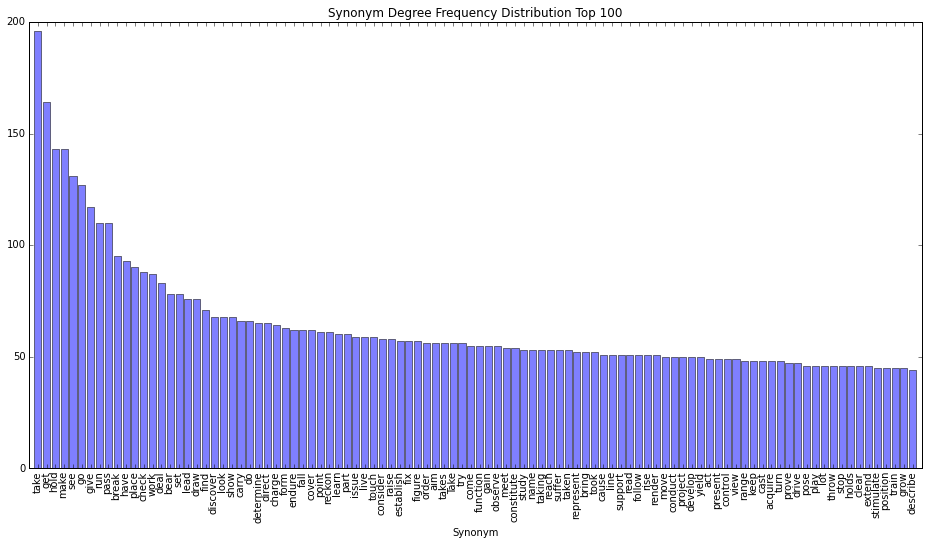

In [19]:
import matplotlib.pyplot as plt
import re
import numpy as np

words = []
counts = []
with open('node_counts.txt','r') as cntFile:
    for line in cntFile.readlines():
        count, word = re.split('\t',line.strip())
        counts.append(int(count))
        words.append(word.strip('"'))

y_pos = np.arange(100)
fig = plt.figure(figsize=(16,8))
plt.bar(y_pos, counts[:100], align='center', alpha=0.5)
plt.xlim(-1,100)
plt.xticks(y_pos, words[:100], rotation=90)
plt.xlabel('Synonym')
plt.title('Synonym Degree Frequency Distribution Top 100')
plt.show()

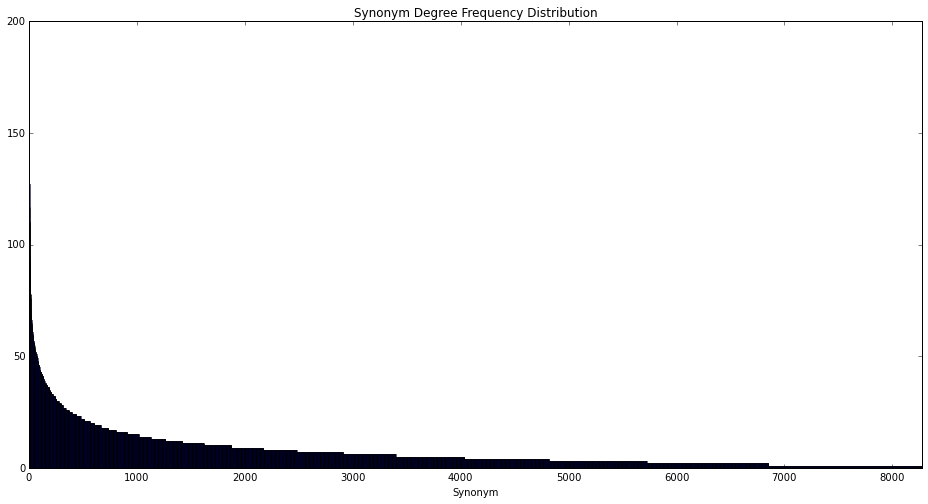

In [20]:
y_pos = np.arange(len(words))
fig = plt.figure(figsize=(16,8))
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xlim(-1,len(words))
#plt.xticks(y_pos, words[:100], rotation=90)
plt.xlabel('Synonym')
plt.title('Synonym Degree Frequency Distribution')
plt.show()

In [25]:
print "Number of Nodes: {0}".format(len(words))
print "Number of Links: {0}".format(sum(counts))
print "Average Degree:  {0}".format(float(sum(counts))/len(words))

Number of Nodes: 8271
Number of Links: 61134
Average Degree:  7.39136742836


## HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). Once you have gotten your code to run locally, deploy it on AWS as a systems test in preparation for our next dataset (which will require AWS).

In [100]:
from MrJobTransform import MrJobTransform
from MrJobGraph70 import MrJobGraph70
from sys import maxint
from shutil import copy
import re

def transform(ifname, ofname):
    # Read the graph file and create the adjacency list with the distance and status payloads
    # graph file has format  node \t {neighbor dict}  where each item in the dict is neighbor: distance
    #
    # Transform this structure to node \t {neighbor dict} \t status
    # The first input line will be assumed to be the start node and therefore be assigned Q status
    # all other nodes in the graph will be assigned U status
    status = 'Q'
    weight = 0
    with open(ofname, 'w+') as qFile:
        with open(ifname, 'rU') as graphFile:
            for line in graphFile.readlines():
                adj_list = re.split('\t',line.strip())
                node = adj_list[0].strip()
                neighbors = eval(adj_list[1].strip())
                value = []
                value.append(neighbors.keys())
                # we are ignoring the weight in the dictionary for now
                value.append(weight)
                value.append(status)
                if status == 'Q':
                    value.append([node])
                    status = 'U'
                    weight = maxint
                else:
                    value.append([])

                qFile.write('{0}\t{1}\n'.format(node, value))

# transform the adjacency list into a priority queue list
def runTransformJob(ifname,ofname):
    mr_job = MrJobTransform(args=[ifname,
                                  '-r', 'emr',
                                  '--conf-path','mrjob.conf',
                                  '--pool-emr-job-flows',
                                  '--startNode', '1'])

    with open (ofname,'w') as graphFile:
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                queue_entry = mr_job.parse_output_line(line)
                graphFile.write(line)
                
def runSSSPJob(qfile, start_node, end_node):
    mr_job = MrJobGraph70(args=[qfile, 
                                '-r', 'emr',
                                '--conf-path','mrjob.conf',
                                '--pool-emr-job-flows'
                               ])

    iterations = 0
    more_nodes_to_visit = True
    while(more_nodes_to_visit):
        iterations += 1
        print 'Iteration: {0}'.format(iterations)
        with open('_queue.txt','w+') as qFile:
            with mr_job.make_runner() as runner:
                runner.CLEANUP_CHOICES='JOB'
                runner.run()
                more_nodes_to_visit = False
                output_line = None
                for line in runner.stream_output():
                    q = mr_job.parse_output_line(line)
                    qFile.write(line)
                    # peek at the q entry status - if one is not visited, keep going
                    status = q[1][2]
                    if status != 'V':
                        more_nodes_to_visit = True
                    else:
                        # if it is Visited, check to see if this is our end node
                        if q[0].strip('"') == str(end_node):
                            output_line = 'Path from node {0} to node {1} is: {2}' \
                                .format(start_node, end_node, q[1][3])
                if output_line:
                    more_nodes_to_visit = False
                    print output_line
                    
        copy('_queue.txt',qfile)

if __name__ == '__main__':
#    transform('data/undirected_toy.txt','queue.txt')
#    transform('data/directed_toy.txt','queue.txt')
    runTransformJob('Data/synNet/synNet.txt','queue.txt')
    runSSSPJob('queue.txt', 7827, 536)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Path from node 7827 to node 536 is: ['1', '2', '310', '572', '585', '536']


In [96]:
%%writefile mrjob.conf
include: /Users/rcordell/.mrjob.conf
runners:
    hadoop:
        hadoop_home: '/usr/local/Cellar/hadoop/2.7.2/libexec'

    emr:
        ssh_tunnel_to_job_tracker : true
        ec2_instance_type : m1.medium
        num_ec2_instances : 1
        enable_emr_debugging: true

Overwriting mrjob.conf


## Main dataset 2: English Wikipedia

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

    A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

    Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
    Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
    Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt
    On under the Data Subfolder for HW7 on Dropbox with the same file names

but has an index with more detailed data:

    (article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values. Here, a weight indicates the number of time a page links to another. However, for the sake of this assignment, treat this an unweighted network, and set all weights to 1 upon data input.

## HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

In [21]:
%%writefile MrJobSynFreq.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import re

class MrJobSynFreq(MRJob):
    SORT_VALUES = True
    
    def configure_options(self):
        super(MrJobSynFreq, self).configure_options()
        self.add_passthrough_option(
            '--idxFile', type='string', default=None)

    # line is  node \t dictionary where dictionary entries are {neighbor : weight}
    def mapper(self, _, line):
        node_entry = re.split('\t',line.strip())
        node = node_entry[0]
        neighbors = eval(node_entry[1])
        for neighbor in neighbors:
            yield neighbor, neighbors[neighbor]
            
    def reducer_init(self):
        self.syn_idx = {}
        with open(self.options.idxFile, 'rU') as idxFile:
            for line in idxFile.readlines():
                idx = re.split('\t',line.strip())
                self.syn_idx[idx[1]]=idx[0]
            
    
    # key=node, values=weights
    def reducer(self, key, values):
        yield self.syn_idx[key], sum(values)
        
    def identity_mapper(self, key, value):
        yield value, key
        
    def sorting_reducer(self, _, values):
        for value in values:
            yield _, value
            
    def steps(self):
        return [MRStep(mapper = self.mapper,
                       reducer_init = self.reducer_init,
                       reducer = self.reducer),
                MRStep(mapper = self.identity_mapper,
                       reducer = self.sorting_reducer,
                       jobconf={'mapred.output.key.comparator.class':
                                'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.comparator.options': '-k1nr -k2',
                                })]
    
if __name__ == "__main__":
    MrJobSynFreq.run()

Writing MrJobSynFreq.py


In [22]:
from MrJobSynFreq import MrJobSynFreq

infile = '/Users/rcordell/Documents/MIDS/W261/week07/HW7/Data/synNet/synNet.txt'
outfile = '/Users/rcordell/Documents/MIDS/W261/week07/HW7/node_counts.txt'
idxFile = '/Users/rcordell/Documents/MIDS/W261/week07/HW7/Data/synNet/indices.txt'

mr_job = MrJobSynFreq(args = [infile,
                                 '-r', 'hadoop',
                                 '--idxFile='+idxFile])

with open(outfile, 'w') as countFile:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            mr_job.parse_output_line(line)
            countFile.write(line)

## HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.

## HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

## HW 7.6: Computational exercise: Largest single-source network distances (optional)

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.

==================END HW 7==================
============================================